In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

In [ ]:
#data_files = glob.glob("/content/drive/MyDrive/MLAssignment3/images/*.jpg")

In [ ]:
data_files = glob.glob("images/*.jpg")

In [ ]:
data_images = []
data_label = []
for img in tqdm(data_files, desc="Loading..."):
  try:
    data_images.append(cv2.resize(cv2.imread(img), (32,32)))
    #label 1 for cats and 0 for dogs
    data_label.append(1 if img.split('/')[-1][0].isupper() else 0)
  except:
    print('Unable to read image:', img)

data_images = np.array(data_images)
data_label = np.array(data_label)
data_images.shape, data_label.shape

Loading...:  48%|████▊     | 3552/7390 [00:22<00:25, 151.02it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Egyptian_Mau_139.jpg


Loading...:  52%|█████▏    | 3806/7390 [00:24<00:23, 154.97it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Egyptian_Mau_145.jpg


Loading...:  60%|██████    | 4449/7390 [00:28<00:19, 148.50it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Egyptian_Mau_191.jpg


Loading...:  61%|██████    | 4480/7390 [00:29<00:19, 149.92it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Egyptian_Mau_177.jpg


Loading...:  68%|██████▊   | 4991/7390 [00:32<00:15, 153.89it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/saint_bernard_42.jpg


Loading...:  92%|█████████▏| 6810/7390 [00:44<00:03, 151.42it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Egyptian_Mau_167.jpg


Loading...:  98%|█████████▊| 7266/7390 [00:47<00:00, 163.23it/s]

Unable to read image: /content/drive/MyDrive/MLAssignment3/images/Abyssinian_34.jpg


Loading...: 100%|██████████| 7390/7390 [00:48<00:00, 153.44it/s]


((7383, 32, 32, 3), (7383,))

In [ ]:
np.unique(data_label, return_counts = True)

(array([0, 1]), array([4989, 2394]))

**1**. (a) PCA

In [ ]:
flatten_imgs = data_images.reshape((data_images.shape[0], 32*32*3))
flatten_imgs.shape

(7383, 3072)

In [ ]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(flatten_imgs)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
pca_features = pca.transform(flatten_imgs)

In [ ]:
pca_features.shape

(7383, 298)

In [ ]:
tsne_on_pca_features = TSNE(n_components=2, verbose=2).fit_transform(pca_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7383 samples in 0.195s...
[t-SNE] Computed neighbors for 7383 samples in 25.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7383
[t-SNE] Computed conditional probabilities for sample 2000 / 7383
[t-SNE] Computed conditional probabilities for sample 3000 / 7383
[t-SNE] Computed conditional probabilities for sample 4000 / 7383
[t-SNE] Computed conditional probabilities for sample 5000 / 7383
[t-SNE] Computed conditional probabilities for sample 6000 / 7383
[t-SNE] Computed conditional probabilities for sample 7000 / 7383
[t-SNE] Computed conditional probabilities for sample 7383 / 7383
[t-SNE] Mean sigma: 166.807325
[t-SNE] Computed conditional probabilities in 0.715s
[t-SNE] Iteration 50: error = 92.8282623, gradient norm = 0.1231119 (50 iterations in 3.898s)
[t-SNE] Iteration 100: error = 91.2852859, gradient norm = 0.1223546 (50 iterations in 3.133s)
[t-SNE] Iteration 150: error = 91.2971039, gradient norm 

No handles with labels found to put in legend.


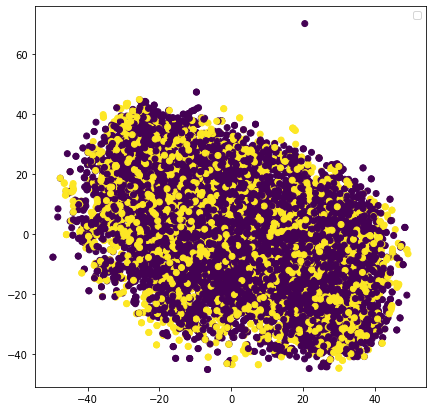

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(tsne_on_pca_features[:,0], tsne_on_pca_features[:, 1], c=data_label)
plt.legend()
plt.show()

**1**. (b) Canny Edge Detection + Color histogram

In [ ]:
from scipy.ndimage.filters import convolve
import random

In [ ]:
# gives gaussain kernel for 1. noise reduction
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(img):
    # img = np.float32(img)
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    
    theta = np.arctan2(Iy, Ix)
    
    return G, theta

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    return Z

def threshold(mag, lowThresholdRatio=0.2, highThresholdRatio=0.3):
    #getting the dimensions of the input image 
    height, width = mag.shape

    highThreshold = mag.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    weak = np.int32(25)
    strong = np.int32(255)
      
    for i_x in range(width):
        for i_y in range(height):
             
            grad_mag = mag[i_y, i_x]
             
            if grad_mag<lowThreshold:
                mag[i_y, i_x]= 0
            elif highThreshold>grad_mag>= lowThreshold:
                mag[i_y, i_x]= weak
            else:
                mag[i_y, i_x]= strong
    
    return mag, weak, strong

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
def canny_detector(img, weak_th = 0.2, strong_th = 0.3):

    #convert RGB to Gray Scale
    # img = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
    img = rgb2gray(img)

    # Noise reduction step
    kernel = gaussian_kernel(size=5, sigma=1.4)
    img = convolve(img, kernel)
      
    # Calculating the gradients
    mag, ang = sobel_filters(img)
    mag = mag.astype(np.int)

    mag = non_max_suppression(mag, ang)

    # double thresholding step
    mag, weak, strong = threshold(mag, lowThresholdRatio=weak_th, highThresholdRatio=strong_th)
   
    mag = hysteresis(mag, weak, strong)

    # finally returning the magnitude of
    # gradients of edges
    return mag

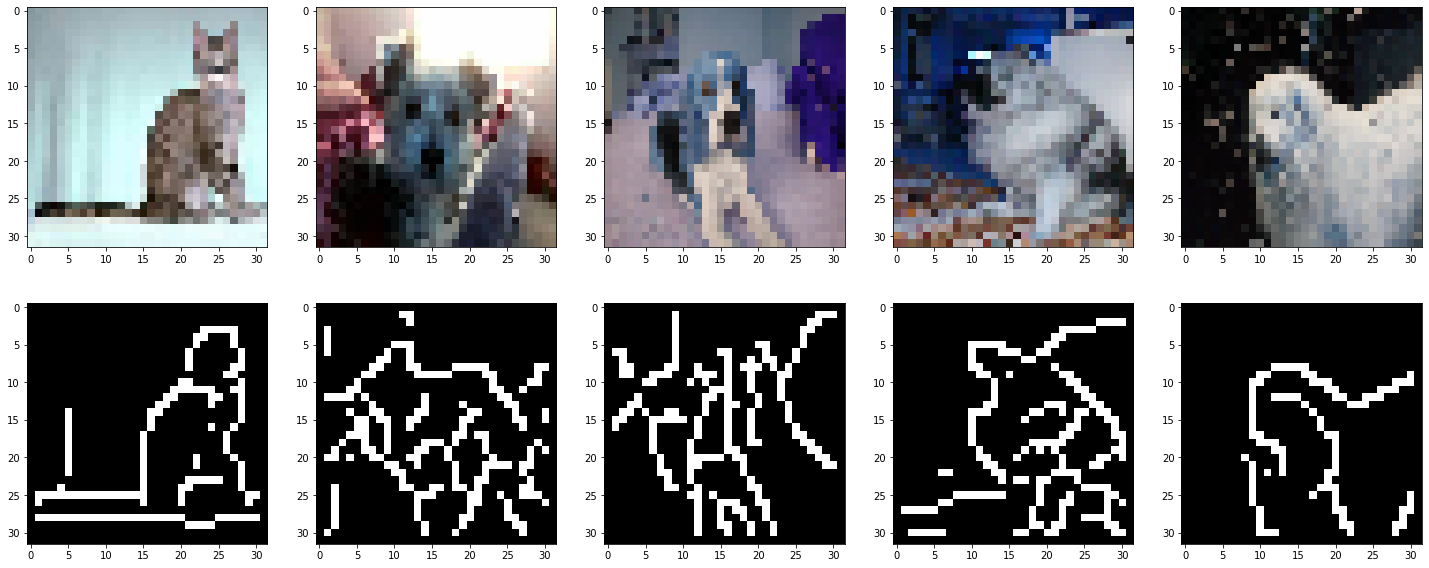

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(25,10))
for i in range(5):
  orig_img = data_images[i] 
  canny_img = canny_detector(orig_img, weak_th = 0.2, strong_th = 0.25)
  ax[0,i].imshow(orig_img)
  ax[1,i].imshow(canny_img, cmap='gray')
plt.show()

In [ ]:
from copy import copy

In [ ]:
def color_histogram(img):
  img_copy = copy(img)
  img_copy[np.where(img > 192)] = 3
  img_copy[np.where((192 >= img) & (img > 128))] = 2
  img_copy[np.where((128 >= img) & (img > 64))] = 1
  img_copy[np.where((64 >= img) & (img >= 0))] = 0
  
  histogram = np.zeros(64)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      histogram[img_copy[i][j][0] * 16  + img_copy[i][j][1] * 4 + img_copy[i][j][2] * 1] += 1
  
  return histogram

In [ ]:
def feature_descriptor2(data):
  new_feature_set = []
  for img in tqdm(data):
    ced = canny_detector(img, weak_th = 0.2, strong_th = 0.25)
    ced = ced.reshape(32*32)
    ch = color_histogram(img)
    features = np.concatenate([ced,ch])
    new_feature_set.append(features)

  return np.array(new_feature_set)

In [ ]:
ced_ch_features = feature_descriptor2(data_images)

100%|██████████| 7383/7383 [02:16<00:00, 54.19it/s]


In [ ]:
tsne_on_ced_ch_features = TSNE(n_components=2, verbose=2).fit_transform(ced_ch_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7383 samples in 0.691s...
[t-SNE] Computed neighbors for 7383 samples in 89.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7383
[t-SNE] Computed conditional probabilities for sample 2000 / 7383
[t-SNE] Computed conditional probabilities for sample 3000 / 7383
[t-SNE] Computed conditional probabilities for sample 4000 / 7383
[t-SNE] Computed conditional probabilities for sample 5000 / 7383
[t-SNE] Computed conditional probabilities for sample 6000 / 7383
[t-SNE] Computed conditional probabilities for sample 7000 / 7383
[t-SNE] Computed conditional probabilities for sample 7383 / 7383
[t-SNE] Mean sigma: 550.923855
[t-SNE] Computed conditional probabilities in 0.750s
[t-SNE] Iteration 50: error = 127.9161072, gradient norm = 0.2199565 (50 iterations in 4.188s)
[t-SNE] Iteration 100: error = 131.2245331, gradient norm = 0.2563667 (50 iterations in 4.903s)
[t-SNE] Iteration 150: error = 135.6310272, gradient no

No handles with labels found to put in legend.


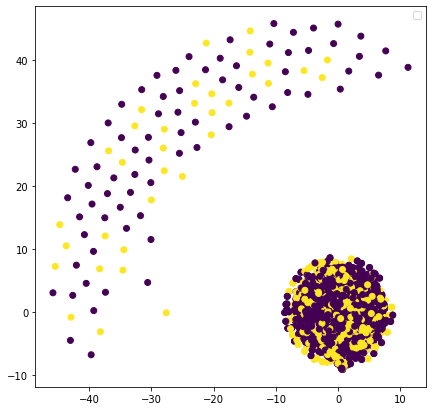

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(tsne_on_ced_ch_features[:,0], tsne_on_ced_ch_features[:, 1], c=data_label)
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm


In [ ]:
#General Function for splitting the data
def splitting(features,target,p):
  splitting_index= int(p * features.shape[0])
  train_X=features[0:splitting_index]
  train_y=target[0:splitting_index]
  test_X=features[splitting_index:]
  test_y= target[splitting_index:]
  return train_X,train_y,test_X,test_y

Q2:3:For PCA data grid search and accuracies

In [ ]:
#Splitting data in 80:20 ratio
train_X_pca,train_y_pca,test_X_pca,test_y_pca= splitting(pca_features,data_label,0.8)


In [ ]:
#Performing gird search cv
parameter_grid = {'C': [0.1,1, 10, 100,1000], 'kernel': ['rbf']}
grid_search_tuning = GridSearchCV(SVC(),parameter_grid,refit=True,verbose=2)
grid_search_tuning.fit(train_X_pca,train_y_pca)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=0.1, kernel=rbf, total=   7.8s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] ................................ C=0.1, kernel=rbf, total=   7.9s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   7.8s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   8.0s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   7.9s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   8.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   8.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   8.0s
[CV] C=1, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print(grid_search_tuning.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
rbf_svm_pca = svm.SVC(kernel='rbf',C=1)
rbf_svm_pca.fit(train_X_pca,train_y_pca)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
rbf_svm_pca.score(train_X_pca,train_y_pca)

0.802065695902472

In [ ]:
rbf_svm_pca.score(test_X_pca,test_y_pca)

0.7149627623561273

Q2:4: PCA data new training set obtained and then svm training and accuracies obtained

In [ ]:
new_pca_trainX = rbf_svm_pca.support_vectors_

In [ ]:
new_pca_trainy = train_y_pca[rbf_svm_pca.support_]

In [ ]:
new_rbf_svm_pca = svm.SVC(kernel='rbf',C=1)
new_rbf_svm_pca.fit(new_pca_trainX,new_pca_trainy)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
new_rbf_svm_pca.score(new_pca_trainX,new_pca_trainy)

0.7361471861471861

In [ ]:
new_rbf_svm_pca.score(test_X_pca,test_y_pca)

0.7163168584969533

Q2:3: For Canny edge and histogram grid search done and accuracies obtained

In [ ]:
train_X,train_y,test_X,test_y= splitting(ced_ch_features,data_label,0.8)


In [ ]:
parameter_grid = {'C': [0.1,1, 10, 100,1000], 'kernel': ['rbf']}

In [ ]:
grid_search_tuning = GridSearchCV(SVC(),parameter_grid,refit=True,verbose=2)
grid_search_tuning.fit(train_X,train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=0.1, kernel=rbf, total=  31.9s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.9s remaining:    0.0s


[CV] ................................ C=0.1, kernel=rbf, total=  31.6s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=  32.1s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=  31.6s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=  32.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  32.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  31.7s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=  34.2s
[CV] C=1, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 14.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print(grid_search_tuning.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
rbf_svm_ced = svm.SVC(kernel='rbf',C=1)
rbf_svm_ced.fit(train_X,train_y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
rbf_svm_ced.score(train_X,train_y)

0.8838469353200136

In [ ]:
rbf_svm_ced.score(test_X,test_y)

0.6953283683141503

Q2:4: Canny edge and histogram data new training set obtained and then svm training and accuracies obtainedQ4

In [ ]:
new_canny_trainX = rbf_svm_ced.support_vectors_

In [ ]:
new_canny_trainy = train_y[rbf_svm_ced.support_]

In [ ]:
new_rbf_svm_canny = svm.SVC(kernel='rbf',C=1)
new_rbf_svm_canny.fit(new_canny_trainX,new_canny_trainy)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
new_rbf_svm_canny.score(new_canny_trainX,new_canny_trainy)

0.8708473310936917

In [ ]:
new_rbf_svm_canny.score(test_X,test_y)

0.6953283683141503